# Dataset Deduplication and Data Leakage

## The Association for Computational Linguistics
## WASSA 2023 Shared Task on Multi-Label and Multi-Class Emotion Classification on Code-Mixed Text Messages
See more details [here](https://codalab.lisn.upsaclay.fr/competitions/10864#learn_the_details)

In [12]:
import openai
import numpy as np
import pandas as pd
import sklearn
import re, os
import time
import zipfile, pickle
from typing import List
from copy import deepcopy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from openai.embeddings_utils import cosine_similarity
from tqdm.autonotebook import tqdm
import random
import tiktoken
import backoff
tqdm.pandas()
#os.path.join()

import matplotlib
matplotlib.style.use('seaborn')    #'seaborn', fivethirtyeight
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
random_state = 47

# Load and Prepare Data

In [51]:
file1    = 'data/mcec_train_translated.pkl'
df_train = pd.read_pickle(file1)

file2    = 'data/mcec_dev_translated.pkl'
df_dev   = pd.read_pickle(file2)

file3    = 'data/mcec_test_withlabels.csv'
df_test  = pd.read_csv(file3)

file4    = 'data/sample_submission/predictions_MCEC.csv'
sample_submission = pd.read_csv(file4)

print(df_train.shape, df_dev.shape, df_test.shape, sample_submission.shape)

(9530, 5) (1191, 12) (1191, 2) (1191, 1)


In [4]:
# submission format
print( type(sample_submission) )
sample_submission.head()

<class 'pandas.core.frame.DataFrame'>


,Emotion
0,neutral
1,neutral
2,pessimism
3,disgust
4,fear


The two cells below were run once to copy the manually arbitrated ChatGPT English translation of code-mixed texts:

In [5]:
# copy manually arbitrated translation into English from column 'gpt_translated2_corrected'
#file = 'data/mcec_dev.xlsx'
#df_dev2 = pd.read_excel( file )
#print(df_dev2.shape)
#df_dev2.head()

In [6]:
#df_dev['gpt_translated2_corrected'] = df_dev2['gpt_translated2_corrected'].values

#file2  = 'data/mcec_dev_translated.pkl'
#df_dev.to_pickle( file2 )

In [5]:
df_train['target'] = df_train['emotion'].apply( lambda x: 0 if x=='neutral' else 1 )
df_dev['target']   = df_dev['emotion'].apply( lambda x: 0 if x=='neutral' else 1 )

In [6]:
print(df_train['emotion'].value_counts(), '\n')
print(df_train['target'].value_counts())
df_train.head()

neutral         3262
trust           1118
joy             1022
optimism         880
anticipation     832
disgust          687
sadness          486
fear             453
anger            226
surprise         199
love             187
pessimism        178
Name: emotion, dtype: int64 

1    6268
0    3262
Name: target, dtype: int64


,text,emotion,translated_hi,translated_ur,gpt_embedding,target
0,Yes.I am in fyp lab cabin.but fyp presentation...,neutral,Yes.i am in fyp lab cabin.but fyp presentation...,Y. Um in Fap Lab Cabin. Butt Fap Presentations...,"[-0.005477939732372761, -0.01738985814154148, ...",0
1,Yar insan ka bcha bn chawliyn na mar :p,joy,"Dude become a child of a human being, do not die.",Dude human beings do not die: P: P,"[0.0006696455529890954, -0.006965265609323978,...",1
2,Terai uncle nai kahna hai kai ham nai to bahr ...,disgust,Your Uncle Nai says that we had sent out money,Your Ankali says that we sent out money and wa...,"[0.021171217784285545, -0.02109299972653389, 0...",1
3,Yr ajao I m cming in the club,neutral,YR AJAO I'M Coming in the Club,Yer organs were the club,"[-0.010511564090847969, -0.02738134376704693, ...",0
4,Mje wese Nimra ahmad ka Qur'aan ki aayaat k ba...,joy,Mje wes nimra ahmad ka qur'aan ki aayaat k bar...,Mje Wese Nimra Ahmad Ka Qur'aan Ki Aayaaat K B...,"[-0.0016743674641475081, -0.021855581551790237...",1


In [10]:
# before deduplication
print(df_dev['emotion'].value_counts(), '\n')
print(df_dev['target'].value_counts())
df_dev.head()

neutral         388
joy             131
trust           125
disgust         113
optimism        110
anticipation     94
sadness          62
fear             52
surprise         35
anger            35
pessimism        29
love             17
Name: emotion, dtype: int64 

1    803
0    388
Name: target, dtype: int64


,text,emotion,target,gtp_translated,translated_hi,translated_ur,text_clean,gpt_pred,gpt_pred_num,gpt_translated2,gpt_translated2_corrected,gpt_embedding
0,Tension lene ki koi baat ni,neutral,0,There's no need to take tension.,There is nothing to take tension,Any talk of taking tangoes,Tension lene ki koi baat ni,neutral,1,There's no need to worry.,There's no need to worry.,"[-0.00021548081713262945, 0.005029499996453524..."
1,Main ghar punch gya hun or ab spny laga hun,neutral,0,I have reached home and now I am going to sleep.,I have gone home punch and now I am Sapni,I have gone home punch and now dreams,Main ghar punch gya hun or ab spny laga hun,neutral,1,I have reached home and now I am going to sleep.,I have reached home and now I am going to sleep.,"[-0.0010164333507418633, -0.013282055966556072..."
2,Nai mje nai mili mail..mene check ki ti,pessimism,1,"I didn't receive any mail, I had checked.",Nai Maje Nai Mile Mail .. I checked,Ni Ni Ni Mille Mail,Nai mje nai mili mail .. mene check ki ti,neutral,1,I didn't receive any new mail. I had checked.,I didn't receive any new mail. I had checked.,"[-0.010691414587199688, -0.01292553823441267, ..."
3,Yr us din mai pura din bzy rahe vo mujy awne h...,disgust,1,"That day, they were busy all day and not givin...",YR Us Din Mai Pura Din Bzy Rahe Vo Mujy Awne H...,Yr us din mai pura din bzy rahe vo mujy awne h...,Yr us din mai pura din bzy rahe vo mujy awne h...,negative,0,"I was busy the whole day on that day, they wer...","I was busy the whole day on that day, they wer...","[0.009936108253896236, -0.016926730051636696, ..."
4,Lakin wo abhe dar dar ka chalata ha,fear,1,But he still walks cautiously.,But it still moves at the rate,But Wu runs the cedar,Lakin wo abhe dar dar ka chalata ha,neutral,1,But he still walks with fear and hesitation.,But he still walks with fear and hesitation.,"[0.019262924790382385, -0.0011249196249991655,..."


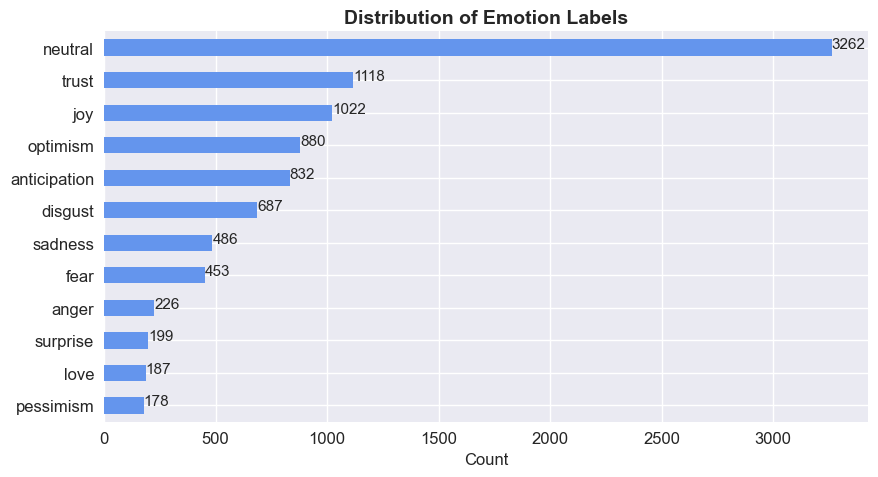

In [21]:
plt.figure( figsize=(9,5))
s = df_train['emotion'].value_counts().sort_values()
ax = s.plot(kind='barh', color='cornflowerblue')
[ax.text(v, i, v, fontsize=11) for i, v in enumerate(s)]
plt.title('Distribution of Emotion Labels', fontweight='bold', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [22]:
# light text cleaning (should I use clean regex for better accuracy?)
pad_punct    = re.compile('([^a-zA-Z ]+)')
multi_spaces = re.compile('\s{2,}')
#clean        = re.compile('[^a-zA-Z0-9,.?!\'\s]+')

def clean_text(s):
    s = s.replace('\n', ' ')
    s = pad_punct.sub(r' \1 ', s)
    #s = clean.sub(' ', s)
    s = multi_spaces.sub(' ', s)
    return s.strip()

df_train['text_clean'] = df_train['text'].apply( clean_text )
df_dev['text_clean']   = df_dev['text'].apply( clean_text )
df_test['text_clean']  = df_test['Text'].apply( clean_text )

In [28]:
# 2K duplicates - these may affect claa imbalance during training! TO BE REDUCED
print(df_train.shape)
temp1 = df_train[ df_train.duplicated(subset=['text_clean'], keep=False) ]
print(temp1.shape)
temp2 = df_train[ df_train.duplicated(subset=['text_clean', 'emotion'], keep=False) ]
print(temp2.shape)
temp3 = df_train[ df_train.duplicated(subset=['text_clean', 'emotion'], keep='first') ]
print(temp3.shape)
print(df_train.drop_duplicates(subset=['text_clean', 'emotion']).shape)

(9530, 7)
(4222, 7)
(4221, 7)
(2367, 7)
(7163, 7)


In [29]:
9530 - 7163

2367

In [27]:
# 82 duplicates ['clean_text', 'emotion'] - can't reduce because this is a dev set
print(df_dev.shape)
temp1 = df_dev[ df_dev.duplicated(subset=['text_clean'], keep=False) ]
print(temp1.shape)
temp2 = df_dev[ df_dev.duplicated(subset=['text_clean', 'emotion'], keep=False) ]
print(df_dev.drop_duplicates(subset=['text_clean', 'emotion']).shape)

(1191, 12)
(82, 12)
(1150, 12)


In [31]:
# 93 complete duplicates - can't reduce because this is a test set
print(df_test.shape)
temp1 = df_test[ df_test.duplicated(subset=['text_clean'], keep=False) ]
print(temp1.shape)
print(df_test.drop_duplicates(subset=['text_clean']).shape)

(1191, 2)
(93, 2)
(1144, 2)


In [32]:
# df_train vs. df_dev: half of the dev set is in train set
overlap1 = [t for t in df_train['text_clean'].values if t in df_dev['text_clean'].values]
overlap2 = [t for t in df_dev['text_clean'].values if t in df_train['text_clean'].values]
len(overlap1), len(overlap2), len(set(overlap1)), len(set(overlap2))

(714, 554, 526, 526)

In [33]:
# df_test vs. rest
overlap3 = [ t for t in df_train['text_clean'].tolist() + df_dev['text_clean'].tolist()\
             if t in df_test['text_clean'].tolist() ]
overlap4 = [ t for t in df_test['text_clean'].tolist() if t in\
             df_train['text_clean'].tolist() + df_dev['text_clean'].tolist() ]
len(overlap3), len(overlap4), len(set(overlap3)), len(set(overlap4))

(817, 584, 557, 557)

In [34]:
# df_test vs. df_dev: half of the dev set is in train set
overlap5 = [t for t in df_dev['text_clean'].values if t in df_test['text_clean'].values]
overlap6 = [t for t in df_test['text_clean'].values if t in df_dev['text_clean'].values]
len(overlap5), len(overlap6), len(set(overlap5)), len(set(overlap6))

(90, 97, 88, 88)

In [35]:
# df_test vs. df_train: half of the dev set is in train set
overlap7 = [t for t in df_train['text_clean'].values if t in df_test['text_clean'].values]
overlap8 = [t for t in df_test['text_clean'].values if t in df_train['text_clean'].values]
len(overlap7), len(overlap8), len(set(overlap7)), len(set(overlap8))

(727, 540, 519, 519)

The reason why baseline ML models perform better than ChatGPT is because they get a lot of hints due to duplicates from the training set! ChatGPT doesn't have this knowledge because it's doing a zero-shot classification! The number of duplicates is such that they would not fit the context window of ChatGPT anyway.

The only way to compare ML and ChatGPT correctly is to remove all the duplicates from the TRAINING SET, then train ML model and test it the dev set and compare with ChatGPT! (also, deduplicate the training set)

Submission: use non-overfit ML or ChatGPT (whichever is better) on those samples from the test set that don't have duplicates in the training or dev set. Use training/dev set labels for the duploicates in the test set.

In [36]:
# remove overlap with validation sets
val_sets = df_dev['text_clean'].tolist() + df_test['text_clean'].tolist()
print(len(val_sets), len(set(val_sets)))

print(df_train.shape)
df_train = df_train[ ~df_train['text_clean'].isin(val_sets) ]
print(df_train.shape)

2382 2206
(9530, 7)
(8151, 7)


In [37]:
# remove duplicates from train set
df_train = df_train.drop_duplicates(subset=['text_clean', 'emotion'])
print(df_train.shape)

(6167, 7)


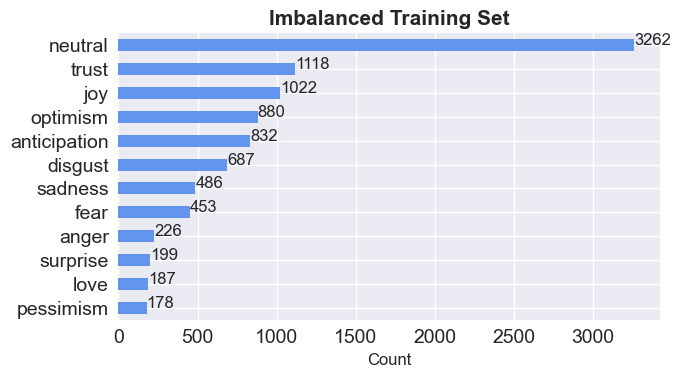

In [55]:
plt.figure( figsize=(7,4))
s = df_train['emotion'].value_counts().sort_values()
ax = s.plot(kind='barh', color='cornflowerblue')
[ax.text(v, i, v, fontsize=12) for i, v in enumerate(s)]
plt.title('Imbalanced Training Set', fontweight='bold', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

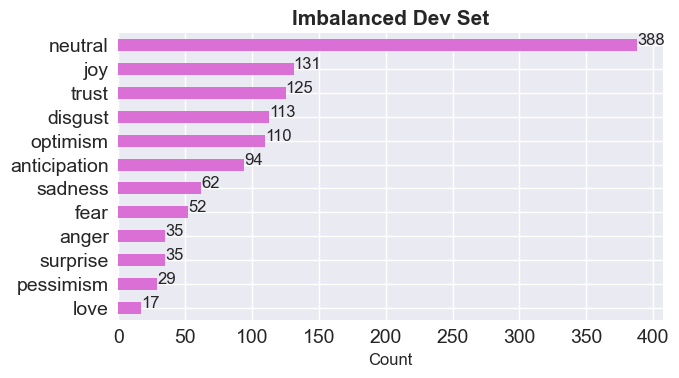

In [59]:
plt.figure( figsize=(7,4))
s = df_dev['emotion'].value_counts().sort_values()
ax = s.plot(kind='barh', color='orchid')
[ax.text(v, i, v, fontsize=12) for i, v in enumerate(s)]
plt.title('Imbalanced Dev Set', fontweight='bold', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

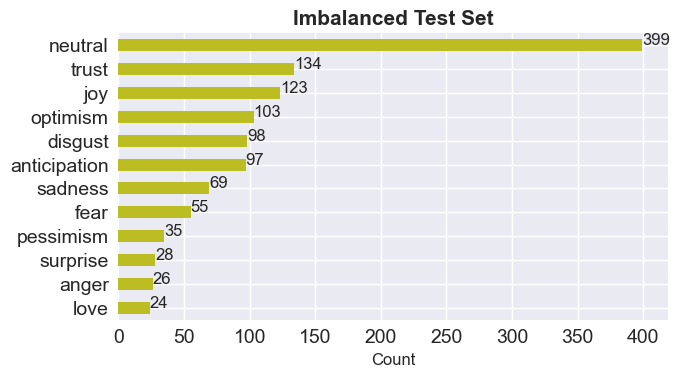

In [61]:
plt.figure( figsize=(7,4))
s = df_test['Emotion'].value_counts().sort_values()
ax = s.plot(kind='barh', color='tab:olive')
[ax.text(v, i, v, fontsize=12) for i, v in enumerate(s)]
plt.title('Imbalanced Test Set', fontweight='bold', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [21]:
# is additional text cleaning necessary? I don't see why
from collections import Counter
train_words = ' '.join( df_train['text_clean'].tolist() ).lower().split()
c = Counter( train_words )
c.most_common(350)

[('.', 2127),
 ('k', 1244),
 ('to', 1231),
 ('ha', 1214),
 ('hai', 804),
 ('ho', 793),
 ('ka', 726),
 ('me', 640),
 ('?', 615),
 ('b', 604),
 ('kr', 568),
 ('ga', 559),
 ('ni', 553),
 ('ko', 543),
 ('ki', 532),
 ('tha', 528),
 (',', 518),
 ('...', 502),
 ('na', 497),
 ('hn', 473),
 ('hy', 464),
 ('wo', 461),
 ('ma', 453),
 ('nai', 450),
 ('..', 450),
 ('a', 446),
 ('se', 415),
 ('p', 409),
 ('yar', 401),
 ('or', 392),
 ('yr', 389),
 ('h', 388),
 ('i', 385),
 ('han', 385),
 ('tu', 371),
 ('e', 331),
 (':', 327),
 ('ne', 324),
 ('kia', 321),
 ('he', 287),
 ('hain', 284),
 ('main', 281),
 ('ab', 254),
 ('koi', 252),
 ('us', 251),
 ('nae', 250),
 ('ap', 250),
 ('sir', 250),
 ('sy', 248),
 ('tm', 237),
 ('is', 223),
 ('nahi', 223),
 ('hi', 222),
 ('raha', 220),
 ('kal', 218),
 ('rha', 214),
 ('ja', 202),
 ('ny', 200),
 ('aj', 199),
 ('g', 199),
 ('m', 198),
 ('phr', 195),
 (':-', 193),
 ('aur', 192),
 ('mai', 192),
 ('....', 187),
 ('gya', 184),
 ('d', 183),
 ('bht', 181),
 ('u', 173),
 ('p

In [22]:
# https://www.kaggle.com/code/owaisraza009/roman-urdu-sentiment-analysis/notebook
stopwords1 = [ 'ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh',
               'rha', 'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya',
               'gaya', 'kch', 'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to', 'is', 'hi', 'jo', 'kya', 'thi', 'se',
               'pe', 'phr', 'wala', 'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski',
               'ne', 'haan', 'acha', 'nai', 'sent', 'photo', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya',
               'dono', 'hoa', 'aese', 'de', 'wohi', 'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi',
               'hova', 'yehi', 'jana', 'jye', 'chal', 'mil', 'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain',
               'krny', 'tou', ]

# https://github.com/haseebelahi/roman-urdu-stopwords.git
file = 'data/stopwords.txt'
stopwords2 = open(file).read().split()
print(stopwords2 == stopwords1)

from sklearn.feature_extraction import _stop_words
stopwords_en  = _stop_words.ENGLISH_STOP_WORDS
# selected from stopwords_en
stopwords_en2 = [ 'a', 'about', 'also', 'am', 'an', 'and', 'are', 'as', 'at', 'be', 
                  'been', 'being', 'by', 'co', 'con', 'de', 'eg', 'eight', 'eleven', 'else', 'etc', 
                  'fifteen', 'fifty', 'five', 'for', 'forty', 'four', 'from', 'had',
                  'has', 'hasnt', 'have', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 
                  'his', 'how', 'i', 'ie', 'if', 'in', 'inc', 'into', 'is', 'it', 'its', 'itself',
                  'ltd', 'me', 'mine', 'my', 'myself', 'nine', 'no', 'now', 'of', 'off', 'on',
                  'once', 'one', 'onto', 'or', 'other', 'others', 'our', 'ours', 'ourselves',
                  'out', 'part', 'per', 're', 'several', 'she', 'side', 'since', 'six', 'sixty',
                  'so', 'ten', 'than', 'that', 'the', 'their', 'them',
                  'themselves', 'then', 'there', 'these', 'they', 'thick', 'thin', 'third', 'this', 'those', 
                  'three', 'to', 'twelve', 'twenty', 'two', 'un','us', 'very',
                  'via', 'was', 'we', 'were', 'what', 'when', 'where', 'whether', 'which', 'while', 
                  'who', 'whom', 'whose', 'why', 'with', 'within', 'would', 'yet', 'you', 'your', 'yours',
                   'yourself', 'yourselves', ]

print( len(stopwords1), len(stopwords_en), len(stopwords_en2), )

True
102 318 129


In [63]:
len(' '.join(df_train['text'].tolist()).split())

116593